# Assessing Utilization
We want to measure how much the system was utilized for different types of loads.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import json
params = {'legend.fontsize': 8,
         'axes.labelsize': 9,
         'axes.titlesize':'x-large',
         'xtick.labelsize': 6,
         'ytick.labelsize': 6}
plt.rcParams.update(params)

## Get the Runs
Load in the different runs that are part of this benchmarking effort

In [2]:
runs = list(Path("./runs/").rglob("config.json"))
print(f'Found {len(runs)} runs')

Found 16 runs


Summarize the runs

In [3]:
def summarize_run(path: Path):
    """Get some details about the run"""
    
    with open(path) as fp:
        config = json.load(fp)
    
    config['path'] = path.parent
    return config

In [4]:
results = pd.DataFrame(summarize_run(x) for x in runs)

## Assess Utilization
Our goal is to measure the utilization at "steady state" after all workers have finished loading in libraries.

We do so by looking at how busy each worker is.
We can measure this by starting the clock on utilization when the first task completes and ending it when the last result finishes.
Utilization for that node is the total time compute was running devided by the time elapsed.

In [5]:
def get_utilization(path: Path):
    """Measure the average utilization of this run"""
    
    # Get the results for each worker
    results = pd.read_json(path / "results.json", lines=True)
    if len(results) == 0:
        return None
    results['worker'] = results['worker_info'].apply(lambda x: f'{x["hostname"]}-{x["PARSL_WORKER_RANK"]}')
    
    # Compute utilization per worker
    utils = []
    results = pd.concat([results, pd.json_normalize(results['timestamp'], sep="_")], axis=1)
    for gid, group in results.groupby('worker'):
        group.sort_values('created', inplace=True)

        # Get the total time running
        start_time = group.iloc[0]['compute_ended']
        end_time = group.iloc[-1]['compute_ended']
        time_elapsed = end_time - start_time

        # Get the total time used
        compute_used = group.iloc[1:]['time'].apply(lambda x: x['running']).sum()

        utils.append(compute_used / time_elapsed)
    
    return np.mean(utils)

In [6]:
results['utilization'] = results['path'].apply(get_utilization)

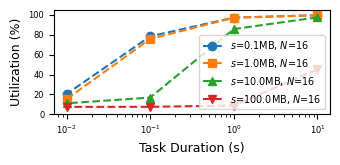

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 1.75))

for (gid, group), m in zip(results.groupby(['task_input_size', 'parallel_tasks']), ['o', 's', '^', 'v']):
    group.sort_values(['task_length', 'utilization'], ascending=False, inplace=True)
    group.drop_duplicates('task_length', inplace=True, keep='first')
    ax.semilogx(group['task_length'], group['utilization'] * 100, '--'+m, label=f'$s$={gid[0]}MB, $N$={gid[1]}')

ax.set_ylim(0, 105)
ax.set_ylabel('Utilization (%)')
ax.set_xlabel('Task Duration (s)')
ax.legend(fontsize=7)

fig.tight_layout()
fig.savefig('performance-envelope.pdf')

In [8]:
results.query('task_length > 5')

,config,local_host,task_input_size,task_output_size,task_count,worker_count,task_length,task_length_std,use_proxystore,proxystore_threshold,reuse_data,output_dir,store_config,parsl_config,parallel_tasks,path,utilization
0,None,True,1.0,1.0,128,16,10.0,0.01,True,1,False,runs,"Store(name=store, connector=RedisConnector(hos...","Config(\n app_cache=True, \n checkpoint_...",16,runs/bettik-linux-2024-05-16_13-39-14,0.997314
3,None,True,100.0,100.0,128,16,10.0,0.01,True,1,False,runs,"Store(name=store, connector=RedisConnector(hos...","Config(\n app_cache=True, \n checkpoint_...",16,runs/bettik-linux-2024-05-16_13-48-09,0.452690
6,None,True,0.1,0.1,128,16,10.0,0.01,True,1,False,runs,"Store(name=store, connector=RedisConnector(hos...","Config(\n app_cache=True, \n checkpoint_...",16,runs/bettik-linux-2024-05-16_13-37-17,0.997465
10,None,True,10.0,10.0,128,16,10.0,0.01,True,1,False,runs,"Store(name=store, connector=RedisConnector(hos...","Config(\n app_cache=True, \n checkpoint_...",16,runs/bettik-linux-2024-05-16_13-41-26,0.976018
